## Logistic Regression

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rc("font",size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid",color_codes=True)

In [2]:
data = pd.read_csv('banking.csv', header = 0)

In [3]:
data = data.dropna()

In [4]:
data.shape

(41188, 21)

In [5]:
data.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
5,30,management,divorced,basic.4y,no,yes,no,cellular,jul,tue,...,8,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,0
6,37,blue-collar,married,basic.4y,no,yes,no,cellular,may,thu,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.327,5099.1,0
7,39,blue-collar,divorced,basic.9y,no,yes,no,cellular,may,fri,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
8,36,admin.,married,university.degree,no,no,no,cellular,jun,mon,...,1,3,1,success,-2.9,92.963,-40.8,1.266,5076.2,1
9,27,blue-collar,single,basic.4y,no,yes,no,cellular,apr,thu,...,2,999,1,failure,-1.8,93.075,-47.1,1.410,5099.1,0


In [6]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

### Processing & EDA

In [7]:
data['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [8]:
# Converting basic.4y etc to basic

data['education'] = np.where(data['education'].str.contains('basic'), 'Basic', data['education'])


In [9]:
data['y'].value_counts()

y
0    36548
1     4640
Name: count, dtype: int64

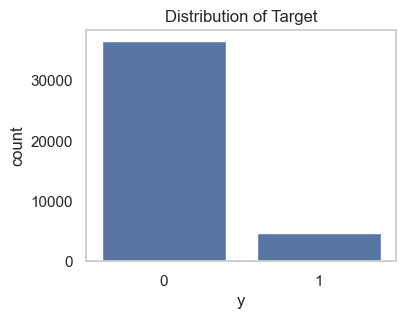

In [10]:
plt.figure(figsize=(4,3))
sns.countplot(x='y',data=data)
plt.title('Distribution of Target')
plt.grid(False)
plt.savefig('count_plot')
plt.show()

In [11]:
data.groupby('y').mean(numeric_only=True)

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


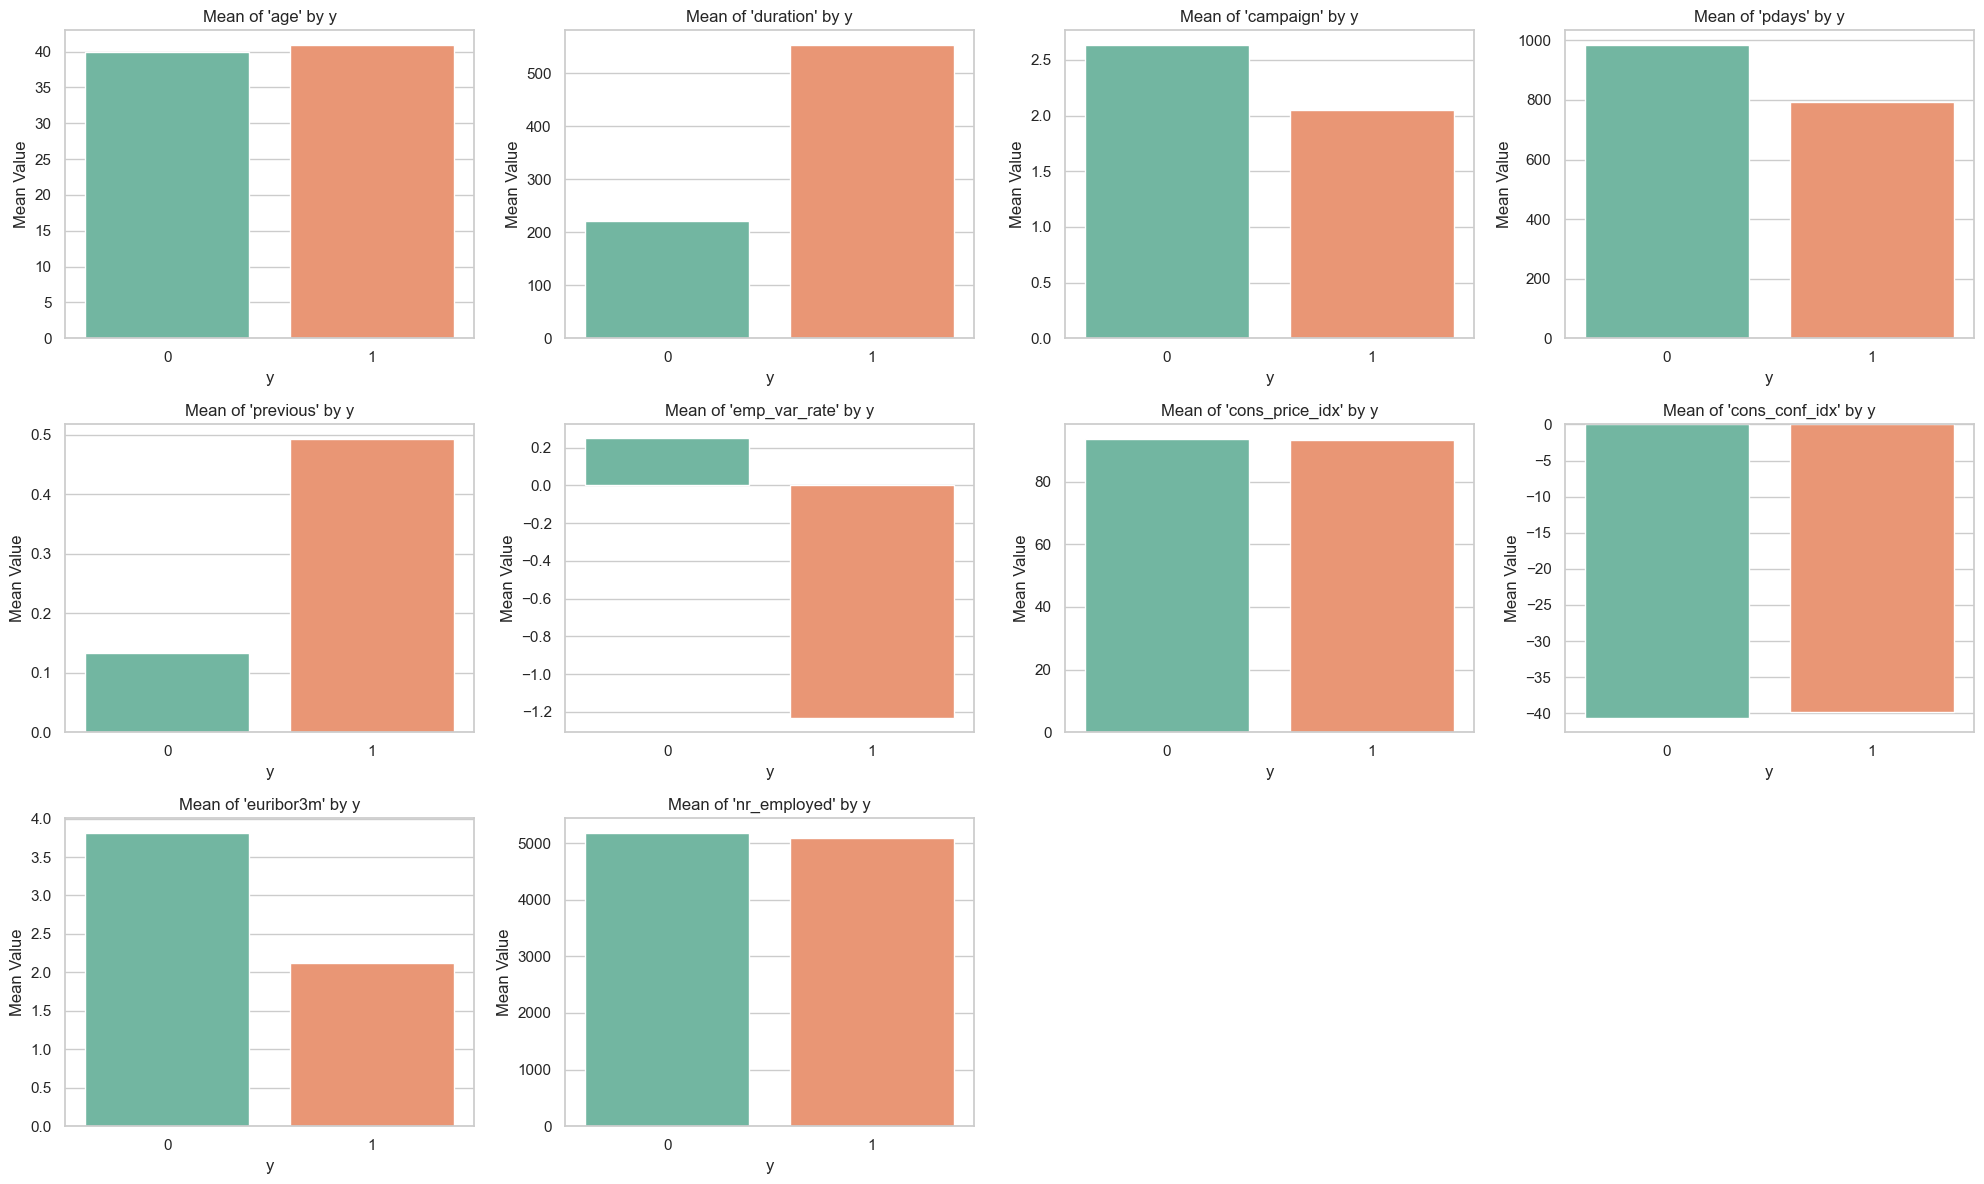

In [46]:
import math
import warnings 
warnings.filterwarnings('ignore')


grouped_means = data.groupby('y').mean(numeric_only=True).T

grouped_means = data.groupby('y').mean(numeric_only=True).T
grouped_means = grouped_means.reset_index().melt(id_vars='index', var_name='y', value_name='mean_value')
grouped_means.rename(columns={'index': 'feature'}, inplace=True)

features = grouped_means['feature'].unique()

n_cols = 4
n_rows = math.ceil(len(features) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()
for i, feature in enumerate(features):
    sns.barplot(
        data=grouped_means[grouped_means['feature'] == feature],
        x='y',
        y='mean_value',
        ax=axes[i],
        palette='Set2'
    )
    axes[i].set_title(f"Mean of '{feature}' by y")
    axes[i].set_xlabel("y")
    axes[i].set_ylabel("Mean Value")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



Observations:

1. Average age of people who converted as higher than those who didn't
2. People who converted were engaged for a longer duration over the call
3. People who converted were exposed to fewer campaigns than those who didn't
4. Negative employment variation is associated with more subscriptions. (During tougher job markets, clients may be more interested in saving (term deposits)) 
5. Lower interest rates are associated with more subscriptions—possibly because term deposits become more attractive relative to other investment options.
6. Subscribing clients had more previous contacts and fewer days since last contact.
7. Slightly lower employment levels when subscriptions are more likely, consistent with the idea of economic uncertainty driving saving behavior.

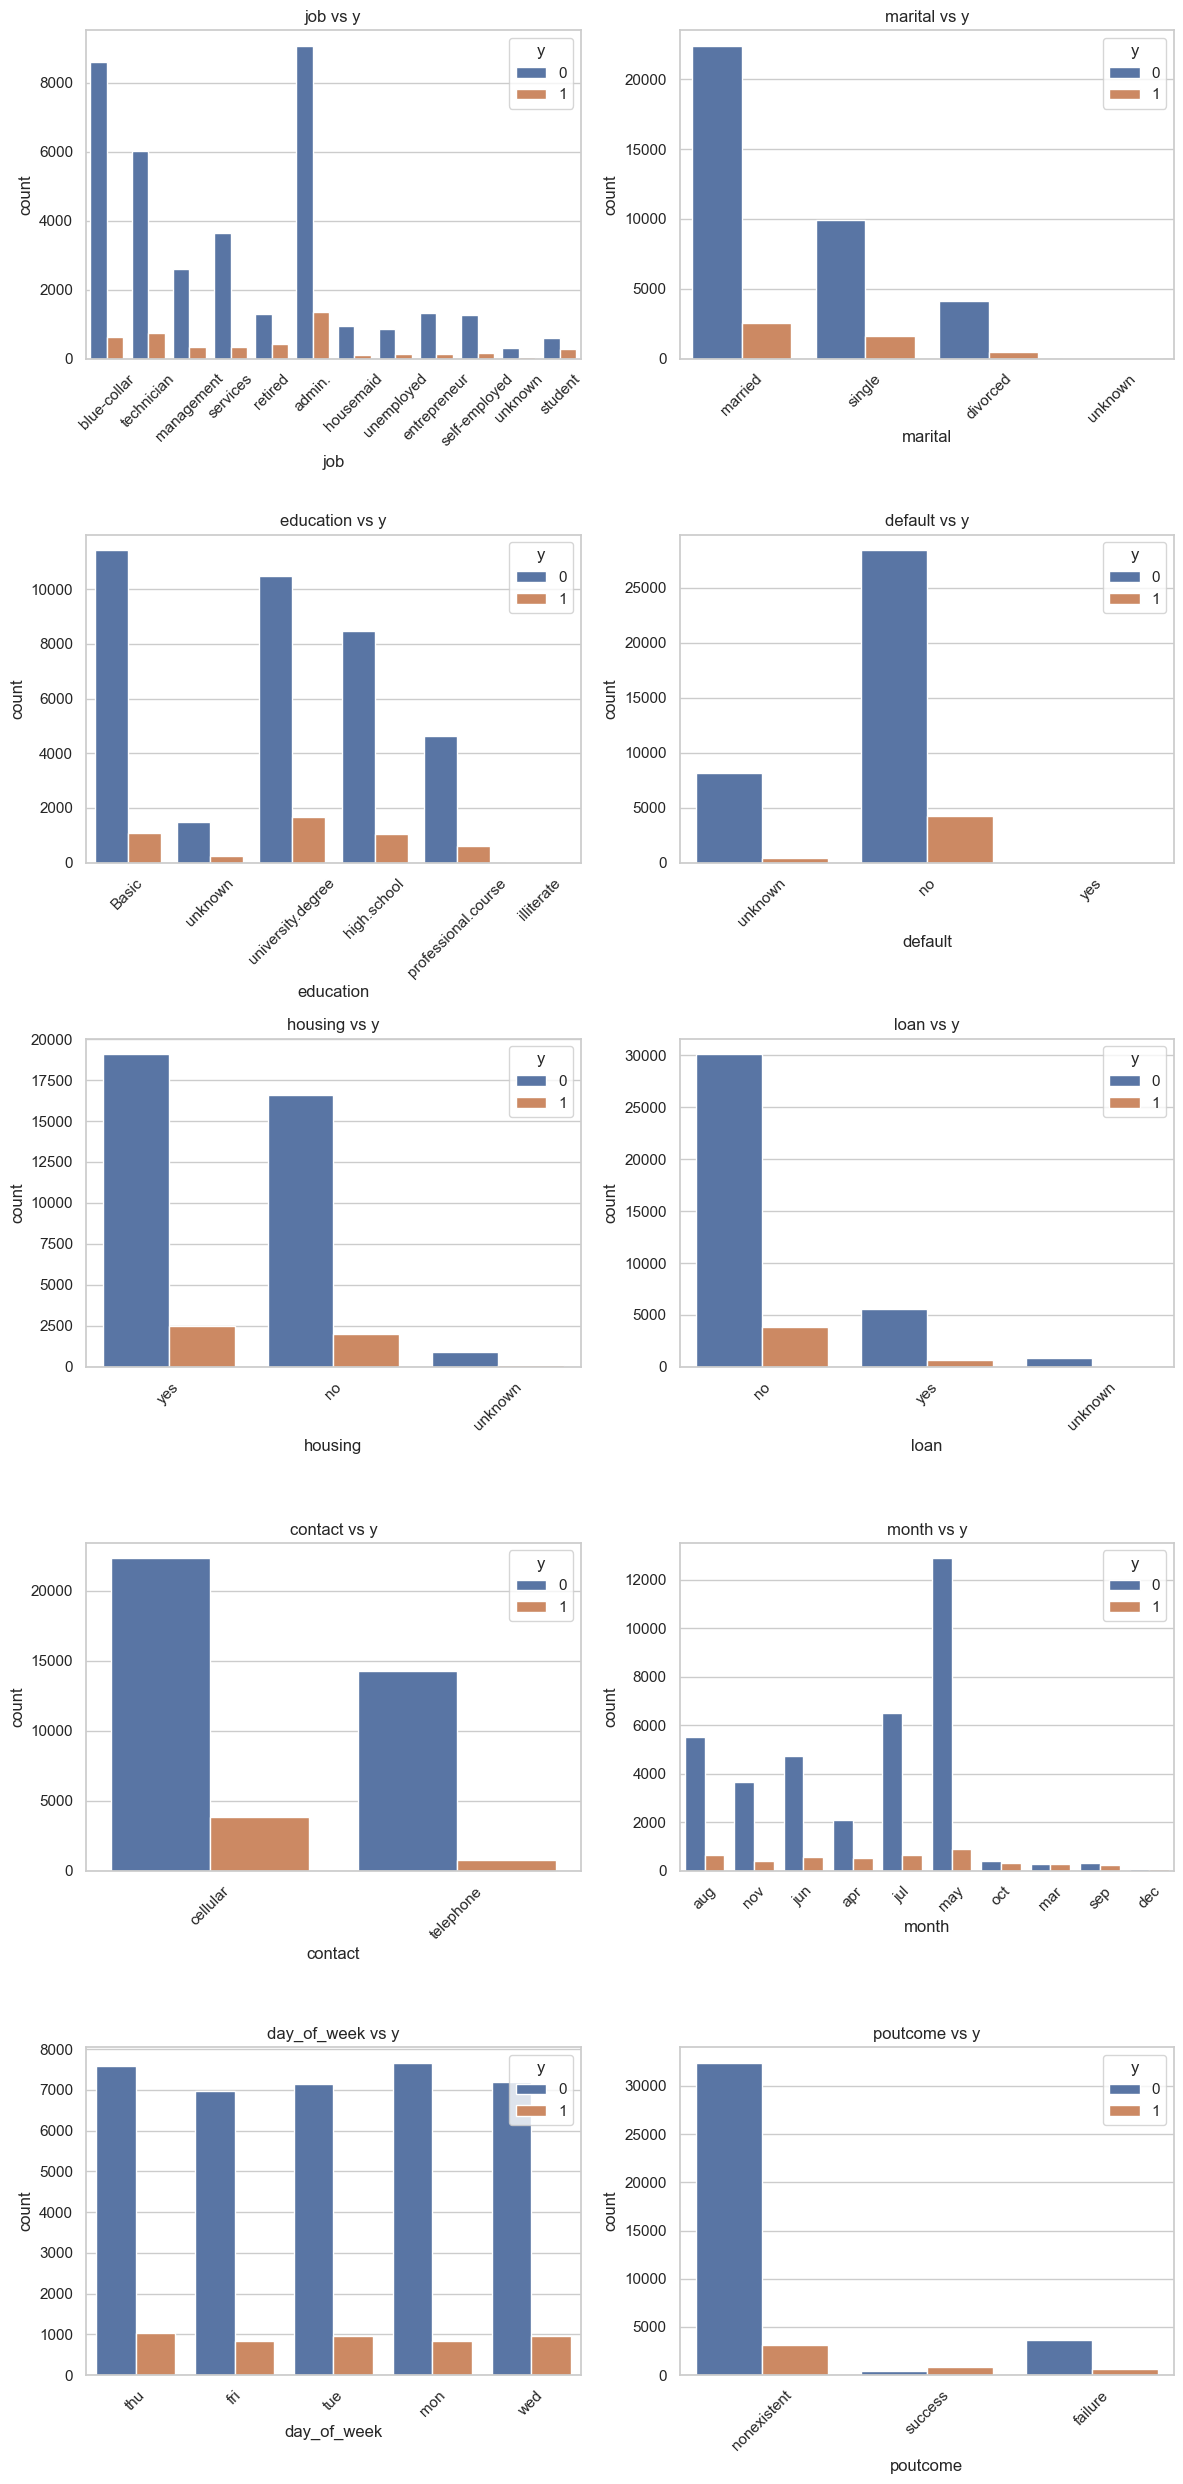

In [14]:
# Plotting the categorical column

categorical_cols = ['job', 'marital', 'education', 
                    'default', 'housing', 'loan', 'contact',
                    'month', 'day_of_week', 'poutcome']


n_cols = 2
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=data, x=col, hue='y', ax=axes[i])
    axes[i].set_title(f'{col} vs y')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [12]:
def getDummies(df, category_cols):
    for col in category_cols:
        dummy_df = pd.get_dummies(df[col], drop_first=True, dtype='int')
        new_col_map = {c: f"{col}_{c}" for c in dummy_df.columns}
        dummy_df.rename(columns=new_col_map,inplace=True)
        df = pd.concat([df,dummy_df],axis=1)
    df.drop(category_cols,axis=1,inplace=True)
    return df

In [24]:
df_bank_1 = getDummies(df=data, category_cols=categorical_cols)

In [25]:
df_bank_1.head(10)

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,44,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,...,0,0,0,0,0,1,0,0,1,0
1,53,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,...,0,1,0,0,0,0,0,0,1,0
2,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,...,0,0,0,0,0,1,0,0,0,1
3,39,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,...,0,0,0,0,0,0,0,0,1,0
4,55,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,...,0,0,0,0,0,0,0,0,0,1
5,30,68,8,999,0,1.4,93.918,-42.7,4.961,5228.1,...,0,0,0,0,0,0,1,0,1,0
6,37,204,1,999,0,-1.8,92.893,-46.2,1.327,5099.1,...,1,0,0,0,0,1,0,0,1,0
7,39,191,1,999,0,-1.8,92.893,-46.2,1.313,5099.1,...,1,0,0,0,0,0,0,0,1,0
8,36,174,1,3,1,-2.9,92.963,-40.8,1.266,5076.2,...,0,0,0,0,1,0,0,0,0,1
9,27,191,2,999,1,-1.8,93.075,-47.1,1.410,5099.1,...,0,0,0,0,0,1,0,0,0,0


In [17]:
df_bank_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 52 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  int64  
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  int64  
 4   previous                       41188 non-null  int64  
 5   emp_var_rate                   41188 non-null  float64
 6   cons_price_idx                 41188 non-null  float64
 7   cons_conf_idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr_employed                    41188 non-null  float64
 10  y                              41188 non-null  int64  
 11  job_blue-collar                41188 non-null  int64  
 12  job_entrepreneur               41188 non-null 

In [18]:
X = df_bank_1

Y = df_bank_1.pop('y')

### Model Building

In [57]:
from sklearn.feature_selection import RFE

logr = LogisticRegression()
rfe = RFE(estimator=logr, n_features_to_select=10)
rfe.fit(X,Y)

RFE(estimator=LogisticRegression(), n_features_to_select=10)

In [60]:
rfe.support_

array([False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True,  True, False,  True,  True, False,
        True, False, False, False, False, False, False,  True])

In [62]:
ranking = pd.DataFrame({
    'Feature': X.columns,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')

In [71]:
selected_features = X.columns[rfe.support_]

In [72]:
selected_features

Index(['euribor3m', 'job_retired', 'job_student', 'default_unknown',
       'month_dec', 'month_jul', 'month_mar', 'month_may', 'month_oct',
       'poutcome_success'],
      dtype='object')

In [74]:
df_bank_1.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown',
       'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_s

In [26]:
columns_final = ["previous", "euribor3m", "job_blue-collar", 
                "job_retired", "job_services", "job_student",
                "month_aug", "month_dec", 
                "month_jul", "month_nov", "month_oct", "month_sep", "day_of_week_wed", 
               "poutcome_nonexistent", "poutcome_success"
                ]

X = df_bank_1[columns_final]
y = df_bank_1['y']

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state=0)
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression()

In [79]:
logreg.coef_

array([[ 0.23194169, -0.50376044, -0.36583153,  0.41475431, -0.21149183,
         0.44987839,  0.37748703,  0.43443695,  0.71252557,  0.32387948,
         0.80248512,  0.72238292,  0.15724483,  0.67034039,  1.85482532]])

In [80]:
logreg.intercept_

array([-1.50280656])

In [28]:
# Accuracy Score 

logreg.score(X_train, y_train)

0.8968124588116957

In [29]:
from sklearn.metrics import classification_report


y_train_pred = logreg.predict(X_train)
print(classification_report(y_train, y_train_pred))


              precision    recall  f1-score   support

           0       0.90      0.99      0.94     25567
           1       0.67      0.17      0.28      3264

    accuracy                           0.90     28831
   macro avg       0.79      0.58      0.61     28831
weighted avg       0.88      0.90      0.87     28831



In [37]:
from sklearn.metrics import confusion_matrix

In [40]:
X_train.shape

(28831, 15)

In [39]:
confusion_matrix(y_train, y_train_pred)

array([[25289,   278],
       [ 2697,   567]])

In [41]:
25289 + 278 + 2697 + 567

28831

In [44]:
200/(25289 + 278 + 2697 + 567)

0.006936977558877597

In [33]:
import math

math.exp(20)

485165195.4097903

In [34]:
1/math.exp(20)

2.061153622438558e-09

In [35]:
1/1.05

0.9523809523809523

In [30]:
#Testing

test_score = logreg.score(X_test, y_test)
print(f"Test Accuracy: {test_score:.4f}")

Test Accuracy: 0.9005
